In [1]:
import numpy as np
from enum import Enum
from IPython.core.display import HTML,display
import pandas as pd
import copy
import random
from collections import deque
import matplotlib.pyplot as plt

# TP final Heurística GRASP para MSA

## Needleman-Wunsch del TP anterior

In [2]:
class op(Enum):
    MA_MM = 0
    GAP_A = 1
    GAP_B = 2
    EMPTY = 3


In [3]:
score_mtx = np.full((4,4),-1) + np.identity(4) *2
score_mtx

array([[ 1., -1., -1., -1.],
       [-1.,  1., -1., -1.],
       [-1., -1.,  1., -1.],
       [-1., -1., -1.,  1.]])

In [4]:
amino= "ACGT"

### TRACEBACK

In [5]:

def traceback(solution_table, seqA, seqB):
    seqA_align = ""
    seqB_align = ""
    i = len(seqA)
    j = len(seqB)
    while i > 0 or j > 0:
        if solution_table[i, j] == op.GAP_A:
            seqA_align = "-" + seqA_align
            seqB_align = seqB[j-1] + seqB_align
            j -= 1
        elif solution_table[i, j] == op.GAP_B:
            seqA_align = seqA[i-1] + seqA_align
            seqB_align = "-" + seqB_align
            i -= 1
        else: # es decir, match / mismatch
            i -= 1
            j -= 1
            seqA_align = seqA[i] + seqA_align
            seqB_align = seqB[j] + seqB_align
    return seqA_align, seqB_align



### Needleman-Wunsch

In [6]:
def nw(seqA_str, seqB_str, score_mtx, gap_score = 0):
    dim_A = len(seqA_str)
    dim_B = len(seqB_str)
    
    table = get_init_value_table(dim_A,dim_B,gap_score)
    memorization_table = get_init_memo_table(dim_A,dim_B)
    for i in range(1,dim_A+1):
        for j in range(1,dim_B+1):
            aminoacid_A = amino.index(seqA_str[i-1])
            aminoacid_B =amino.index(seqB_str[j-1])
            
            match_or_mismatch_value = table[i-1][j-1] + score_mtx[aminoacid_A][aminoacid_B]

            gap_A_value = table[i][j-1] + gap_score
            gap_B_value = table[i-1][j] + gap_score
            values = [match_or_mismatch_value, gap_A_value, gap_B_value]
            index_min = max(range(len(values)), key=values.__getitem__)
            table[i][j] = values[index_min]
                        
            memorization_table[i][j] = op(index_min)                     
            
    aln_a, aln_b = traceback(memorization_table,seqA_str, seqB_str)
    return aln_a, aln_b, table[dim_A, dim_B]


 
    

def get_init_value_table(x,y,gap_score):
    table = np.zeros((x+1, y+1))
    for i in range(0,y+1):
        table[0,i] = gap_score * i
    for j in range(0,x+1): 
        table[j,0] = gap_score * j
    return table



-------

# Profile

La clase Profile contendra:
- El conteo de los nucleotidos de las secuencias alineadas
- Una lista con todas las alineaciones al momento
- La cantidad de alineaciones alojadas en profile
- El tamaño de las secuencias alojadas
- Un parser sobre nucleotidos.

In [7]:
class Profile:

    def __init__(self):
        self.counter = [[],[],[],[],[]]
        self.sequences = []
        self.size_sequences= 0
        self.seq_numbers = 0
        self.score_history = 0
        self.parser= {"A":0,"C":1,"G":2,"T":3,"-":4}

    def add_sequence(self, sequence, score):
        if(self.size_sequences < len(sequence)):
            for a in range(0,5):
                self.counter[a] = self.counter[a] + ([0] * (len(sequence)-self.size_sequences))
            self.size_sequences= len(sequence)
        self.seq_numbers += 1
        self.score_history = score
        self.sequences.append(sequence)
        for idx, val in enumerate(sequence):
            self.counter[self.parser[val]][idx] += 1
    
    def add_gap_counter(self, position):
        for idx, seq in enumerate(self.sequences):
            self.sequences[idx] = self.insert_gap(seq,position)
        for a in range(0,4):
            self.counter[a].insert(position,0)
        self.counter[4].insert(position, self.seq_numbers)
        self.size_sequences += 1
    
    
    def load_new_align(self, seq_align, score, gaps_profile):

        p.add_sequence(seq_align,score)
    
    def insert_gap(self, a_string, position):
        return a_string[:position] + "-" + a_string[position:]
    
    def get_count_position(self,position):
        count = []
        for a in range(0,5):
            count.append( self.counter[a][position] / self.seq_numbers)
        return tuple(count)
        #return self.counter[0,position], self.counter[1,position], self.counter[2,position], self.counter[3,position]
        
    def print_seq(self):
        print(np.array(self.sequences).reshape(self.seq_numbers,1))
        display(headers_table(np.array(self.counter),"ACGT-",range(1,self.size_sequences+1)))
        
    def print_seq_period(self,i,f):
        print(np.array(self.sequences).reshape(self.seq_numbers,1))
        display(headers_table(np.array(self.counter)[i:f],"ACGT-",range(1,self.size_sequences+1)[i:f]))
        
            
def headers_table(table, header,col_header):
    row_labels = [label for label in header]
    column_labels = [label for label in col_header]
    df = pd.DataFrame(table,index=row_labels,columns=column_labels)
    table_html = df.to_html()
    return HTML(table_html)

#### Pruebas sobre profile

In [8]:
p = Profile()
p.add_sequence("TA-TA",2)
p.add_sequence("T-CT",2)

p.add_gap_counter(2)
p.add_gap_counter(5)
p.print_seq()
p.size_sequences
p.get_count_position(0)
p.score_history

[['TA--T-A']
 ['T--CT-']]


,1,2,3,4,5,6,7
A,0,1,0,0,0,0,1
C,0,0,0,1,0,0,0
G,0,0,0,0,0,0,0
T,2,0,0,0,2,0,0
-,0,1,2,1,0,2,0


2

In [9]:
a_string= [0,0,0,0,0]
a_string.insert(2,2)
a_string

[0, 0, 2, 0, 0, 0]

### Needleman-Wunsch MSA

In [10]:
def nw_msa(seq_str, profile, score_mtx, gap_score = 0):
    dim_seq = len(seq_str)
    dim_profile = profile.size_sequences
    
    table = get_init_value_table(dim_seq,dim_profile,gap_score)
    memorization_table = get_init_memo_table(dim_seq,dim_profile)
    for i in range(1,dim_seq+1):
        for j in range(1,dim_profile+1):
            nucleotide = nucleotide_index(seq_str[i-1])
            
            a, c, g, t, gap = profile.get_count_position(j-1)
            score_position = a * score_mtx[nucleotide][nucleotide_index("A")] + c * score_mtx[nucleotide][nucleotide_index("C")]+ g * score_mtx[nucleotide][nucleotide_index("G")]+ t * score_mtx[nucleotide][nucleotide_index("T")]
            gap_porcent_value = 1 - (a+c+g+t)
            match_or_mismatch_value = table[i-1][j-1] + score_position
            
            gap_profile_value = table[i][j-1] + gap_score
                                             
            gap_seq_value = table[i-1][j] + (gap_score * gap_porcent_value)
            values = [match_or_mismatch_value, gap_profile_value, gap_seq_value]
            index_min = max(range(len(values)), key=values.__getitem__)
            table[i][j] = values[index_min]
                        
            memorization_table[i][j] = op(index_min)
    aln_seq, gaps_profile = traceback_msa(memorization_table,seq_str, profile)
    return aln_seq, gaps_profile, table[dim_seq, dim_profile]

nucleotides= "ACGT-"


def get_init_memo_table(dim_A,dim_B):
    table = np.full((dim_A+1,dim_B+1),op.EMPTY)
    for i in range(1,dim_B+1):
        table[0][i] = op.GAP_A
    for j in range(1,dim_A+1):
        table[j][0] = op.GAP_B
    return table

def nucleotide_index(nucleotide):
    return nucleotides.index(nucleotide)

### traceback msa

In [11]:

def traceback_msa(solution_table, seq, profile):
    seq_align = ""
    gaps_profile = []
    i = len(seq)
    j = profile.size_sequences
    while i > 0 or j > 0:
        if solution_table[i, j] == op.GAP_A:
 
            seq_align = "-" + seq_align
            j -= 1
        elif solution_table[i, j] == op.GAP_B:
            seq_align = seq[i-1] + seq_align
            gaps_profile.append(i-1)
            i -= 1
        else: # es decir, match / mismatch
            i -= 1
            j -= 1
            seq_align = seq[i] + seq_align
    return seq_align, gaps_profile

### Pruebas sobre Needleman-Wunsch MSA

In [12]:
seq1= "TATA"
seq2= "TCT"
alig1,alig2,score = nw(seq1,seq2,score_mtx,0)

In [13]:
p = Profile()

p.add_sequence(alig1,score) #"TA-TA"
p.add_sequence(alig2,score) #"T-CT-"

p.print_seq()

[['TA-TA']
 ['T-CT-']]


,1,2,3,4,5
A,0,1,0,0,1
C,0,0,1,0,0
G,0,0,0,0,0
T,2,0,0,2,0
-,0,1,1,0,1


In [14]:
seq_align, gaps_profile, score = nw_msa("TTTT", p, score_mtx, -1)

for position_gap in gaps_profile:
    p.add_gap_counter(position_gap)
p.add_sequence(seq_align,score)

p.print_seq()
p.score_history

[['TA-TA']
 ['T-CT-']
 ['T-TTT']]


,1,2,3,4,5
A,0,1,0,0,1
C,0,0,1,0,0
G,0,0,0,0,0
T,3,0,1,3,1
-,0,2,1,0,1


0.0

### Prueba datos reales

cargamos los datos de un archivo y lo parseamos para obtener solo sus secuencias.

In [15]:
def read_fasta(fp):
        name, seq = None, []
        for line in fp:
            line = line.rstrip()
            if line.startswith(">"):
                if name: yield (name, ''.join(seq))
                name, seq = line, []
            else:
                seq.append(line)
        if name: yield (name, ''.join(seq))
def get_fasta_sequences(file):
    seqs = []
    with open(file) as fp:
        for name, seq in read_fasta(fp):
            seqs.append(seq)
    return seqs

seqs = get_fasta_sequences('hemog.fasta')

### Creacion de entorno

Alineamos las dos primeras secuencias

In [16]:
seq1= seqs[0]
seq2= seqs[1]
alig1,alig2,score = nw(seq1,seq2,score_mtx,-3)

Creamos nuestro profile y agregamos los dos alineamientos al profile

In [17]:
p = Profile()

p.add_sequence(alig1, score) 
p.add_sequence(alig2, score)

p.print_seq()

[['ATGGTGCTGTCTACCGCTGACAAGAACAACGTGAAGACTACCTGGGACAAGATTGGCGGCCATGCTCCAGAATACGTAGCCGAGGGCCTGACCAGGATGTTTACGAGTTTCCCAACCACCAAGACCTACTTCCACCACATAGATGTGAGCCCGGGCTCCGGCGATATCAAGGCCCATGGCAAGAAGGTGGCAGACGCGCTAACCACTGCCGTGGGCCATCTGGACGATCTGCCCACTGCCCTGTCGACTCTGAGTGACGTGCATGCCCACAAGCTGCGTGTGGACCCCGTAAACTTCAAGTTCCTGAACCACTGCCTGCTGGTGACGCTGGCTGCTCACCTTGGAGCAGATTTCACCCCCTCGATCCATGCCTCCTTGGACAAATTCTTTGCCTCTGTGAGCACCGTGCTGACTTCCAAATACCGCTAA']
 ['ATGGTGCTGTCTACCGCTGACAAGAACAACGTGAAGACTACCTGGGACAAGATTGGCGGCCATGCTCCAGAATACGTAGCCGAGGGCCTGACCAGGATGTTTACGAGTTTCCCAACCACCAAGACCTACTTCCACCACATAGATGTGAGCCCGGGCTCCGGCGATATCAAGGCCCATGGCAAGAAGGTGGCAGACGCGCTAACCACTGCCGTGGGCCATCTGGACGATCTGCCCACTGCCCTGTCGACTCTGAGTGACGTGCATGCCCACAAGCTGCGTGTGGACCCCGTAAACTTCAAGTTCCTGAACCACTGCCTGCTGGTGACGCTGGCTGCTCACCTCGGAGCAGATTTCACCCCCTCGATCCATGCCTCCTTGGACAAATTCTTTGCCTCTGTGAGCACCGTGCTGACTTCC----A-----AA']]


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429
A,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,2,2,0,2,2,0,2,2,0,0,0,0,2,2,0,2,0,0,2,0,0,0,0,0,0,2,0,2,2,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,2,2,0,2,0,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,2,0,0,2,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,2,2,0,0,2,0,0,2,2,0,2,0,0,0,2,0,0,0,0,0,2,0,0,2,0,2,0,2,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,2,2,0,0,0,0,0,2,0,0,0,0,2,2,0,2,2,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,2,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,2,2,0,0,0,0,2,2,0,0,0,0,0,0,0,2,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,2,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,1,0,2,0,0,0,0,0,2,2
C,0,0,0,0,0,0,2,0,0,0,2,0,0,2,2,0,2,0,0,0,2,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,2,0,0,2,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,2,2,0,0,0,2,0,2,2,0,0,0,0,0,0,2,0,0,0,0,2,2,0,0,0,0,0,2,2,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,2,2,0,0,2,2,0,2,2,0,0,0,0,2,2,0,0,2,0,0,2,2,0,2,2,0,2,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,2,0,2,2,0,0,2,0,0,0,0,0,2,0,0,0,0,2,2,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,2,0,2,0,0,0,2,2,0,2,0,0,2,2,0,0,0,0,0,2,2,0,0,2,0,0,0,0,2,0,0,0,2,0,0,2,2,2,0,2,0,0,2,2,2,0,0,0,2,0,0,2,0,2,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,2,2,2,0,2,0,0,0,2,0,0,2,0,0,0,0,0,0,0,2,2,2,2,0,0,0,0,0,2,0,0,2,0,0,0,0,0,2,2,0,0,0,0,2,2,0,2,0,0,2,2,0,0,2,0,0,0,0,0,0,2,0,2,0,0,0,2,0,0,2,0,2,0,2,2,0,1,0,0,0,0,2,0,0,0,0,0,0,2,0,2,2,2,2,2,0,2,0,0,0,2,2,0,0,0,2,2,0,2,2,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,2,2,0,2,0,0,0,0,0,0,2,0,2,2,0,0,0,2,0,0,0,2,0,0,2,2,0,0,0,0,0,1,1,0,1,0,0,0
G,0,0,2,2,0,2,0,0,2,0,0,0,0,0,0,2,0,0,2,0,0,0,0,2,0,0,0,0,0,0,2,0,2,0,0,2,0,0,0,0,0,0,0,2,2,2,0,0,0,0,2,0,0,0,2,2,0,2,2,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,2,0,0,2,0,0,2,0,2,2,2,0,0,0,2,0,0,0,0,2,2,0,0,2,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,2,0,0,0,2,2,2,0,0,0,0,2,2,0,2,0,0,0,0,0,0,0,2,2,0,0,0,0,0,2,2,0,0,0,2,0,0,2,2,0,2,2,0,0,2,0,0,2,0,2,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,2,2,0,0,0,0,0,0,2,2,0,0,2,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,2,0,0,2,0,0,0,0,0,2,0,2,0,2,0,0,2,0,2,0,0,0,2,0,0,0,0,0,0,0,2,0,0,2,0,2,0,2,0,2,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,2,0,0,2,2,0,2,0,0,2,0,0,2,2,0,0,2,0

#### Vamos a alinear las secuencias restantes

In [18]:
for fa in seqs[2:]:
    seq_align, gaps_profile, score = nw_msa(fa, p, score_mtx, -10)

    p.load_new_align(seq_align,score, gaps_profile)
        
p.print_seq()
p.score_history

[['ATGGTGCTGTCTACCGCTGACAAGAACAACGTGAAGACTACCTGGGACAAGATTGGCGGCCATGCTCCAGAATACGTAGCCGAGGGCCTGACCAGGATGTTTACGAGTTTCCCAACCACCAAGACCTACTTCCACCACATAGATGTGAGCCCGGGCTCCGGCGATATCAAGGCCCATGGCAAGAAGGTGGCAGACGCGCTAACCACTGCCGTGGGCCATCTGGACGATCTGCCCACTGCCCTGTCGACTCTGAGTGACGTGCATGCCCACAAGCTGCGTGTGGACCCCGTAAACTTCAAGTTCCTGAACCACTGCCTGCTGGTGACGCTGGCTGCTCACCTTGGAGCAGATTTCACCCCCTCGATCCATGCCTCCTTGGACAAATTCTTTGCCTCTGTGAGCACCGTGCTGACTTCCAAATACCGCTAA']
 ['ATGGTGCTGTCTACCGCTGACAAGAACAACGTGAAGACTACCTGGGACAAGATTGGCGGCCATGCTCCAGAATACGTAGCCGAGGGCCTGACCAGGATGTTTACGAGTTTCCCAACCACCAAGACCTACTTCCACCACATAGATGTGAGCCCGGGCTCCGGCGATATCAAGGCCCATGGCAAGAAGGTGGCAGACGCGCTAACCACTGCCGTGGGCCATCTGGACGATCTGCCCACTGCCCTGTCGACTCTGAGTGACGTGCATGCCCACAAGCTGCGTGTGGACCCCGTAAACTTCAAGTTCCTGAACCACTGCCTGCTGGTGACGCTGGCTGCTCACCTCGGAGCAGATTTCACCCCCTCGATCCATGCCTCCTTGGACAAATTCTTTGCCTCTGTGAGCACCGTGCTGACTTCC----A-----AA']
 ['ATGGTGCTGTCTGCCGCTGACAAGAACAACGTGAAGACTACCTGGGACAAGATTGGCGGCCATGCTGCAGAATACGTAGCCGAGGGCCTGACCAGGATGTTTACGAGTTTCCCAACCACCAAGACCT

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429
A,8,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,8,0,8,8,0,8,3,0,8,8,0,0,0,0,8,8,0,7,0,0,3,0,0,0,0,0,0,4,0,8,8,0,8,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,3,0,8,7,0,8,0,0,0,3,0,0,0,0,8,0,0,0,0,0,0,0,3,0,0,8,0,0,8,0,0,0,0,0,3,0,1,8,0,0,0,0,0,0,0,8,8,0,0,8,0,0,8,8,0,8,0,0,0,8,0,0,0,0,0,8,0,0,8,0,3,0,3,0,8,0,2,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,8,0,0,8,8,0,4,0,0,0,8,0,0,0,0,8,8,0,8,8,0,0,0,0,0,0,3,0,8,0,0,0,0,0,0,8,8,0,0,7,0,0,0,0,0,0,0,0,0,4,2,0,8,0,0,0,0,0,8,0,0,8,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,8,0,0,0,8,0,0,0,0,0,8,0,0,0,0,0,8,0,8,8,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,3,8,8,0,0,0,0,8,8,0,0,0,0,0,0,0,8,3,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,5,0,0,0,7,0,0,8,0,8,1,0,0,0,8,0,0,0,0,0,0,0,1,4,0,0,0,8,0,0,0,0,0,0,0,2,0,0,0,8,0,8,8,8,0,0,0,0,0,0,1,0,0,5,0,0,0,0,0,8,0,0,8,0,0,0,0,0,0,0,0,7,0,0,0,0,0,4,5,5,1,5,1,0,0,0,0,5,7
C,0,0,0,0,0,0,8,0,0,0,8,0,5,8,3,0,8,0,0,0,8,0,0,0,0,5,8,0,0,8,0,0,0,0,0,0,0,8,0,0,8,8,0,0,0,0,0,8,0,0,0,0,0,0,0,0,4,0,0,8,8,0,0,0,3,0,2,8,0,0,0,0,0,0,4,0,0,5,0,8,3,0,0,0,0,5,8,8,0,0,0,3,7,0,0,0,0,0,0,0,0,5,5,3,0,0,0,0,0,0,7,8,8,0,0,8,8,0,8,3,0,0,0,0,8,8,0,0,3,0,0,8,8,0,4,8,0,6,0,0,5,0,0,5,0,0,0,0,0,8,3,8,0,0,0,8,0,8,8,0,5,4,5,0,0,0,0,8,0,0,0,0,4,8,8,0,1,0,0,8,0,0,0,0,0,0,0,0,0,0,8,0,0,0,3,0,8,0,8,0,0,0,8,8,1,7,1,0,8,3,0,0,0,0,0,6,8,0,0,8,0,0,0,0,8,0,0,5,8,0,0,8,8,8,0,8,0,0,8,8,8,0,0,0,8,0,0,8,0,8,0,0,0,0,5,0,0,8,5,0,0,8,0,5,0,8,8,8,0,8,0,0,0,8,0,0,8,0,0,0,0,0,0,0,8,8,8,8,0,0,0,0,0,8,0,0,8,0,0,0,5,0,8,8,0,0,0,0,8,8,0,8,0,0,8,8,0,0,8,0,4,0,0,0,0,8,0,7,0,0,0,8,0,0,8,5,8,0,8,8,0,7,5,5,0,0,8,0,0,0,0,0,0,8,0,8,8,8,8,7,0,8,0,0,1,3,8,0,0,0,8,8,0,8,8,0,0,0,0,0,8,0,0,0,0,0,8,0,0,0,0,7,8,0,8,0,0,0,0,0,0,8,0,8,8,0,0,0,8,0,0,0,7,0,0,7,8,0,0,0,0,1,3,4,0,2,0,0,0
G,0,0,8,8,0,8,0,0,8,0,0,0,1,0,0,8,0,0,8,0,0,0,0,8,0,0,0,0,0,0,8,0,8,0,0,8,1,0,0,5,0,0,0,8,8,8,4,0,0,0,8,0,0,0,8,8,0,8,8,0,0,0,0,8,5,0,6,0,5,8,0,0,0,0,0,8,5,0,8,0,5,8,0,8,8,3,0,0,0,8,0,1,1,0,8,8,0,0,8,0,0,0,0,0,7,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,3,0,8,0,8,0,5,0,8,8,8,0,0,0,0,8,3,0,3,0,5,0,0,0,0,0,8,4,4,0,0,0,0,8,8,0,0,0,8,0,0,8,8,0,8,4,0,5,8,0,1,8,0,8,0,0,0,0,0,0,0,0,0,8,0,0,8,0,8,8,4,0,0,0,0,0,0,8,8,0,0,8,0,0,0,0,8,0,0,0,0,0,0,8,0,0,0,0,7,0,0,4,5,0,0,0,0,8,0,8,0,8,0,0,3,0,8,0,0,0,8,0,0,0,0,0,0,0,8,0,0,8,0,8,0,8,0,8,8,0,0,0,0,0,8,0,5,0,0,0,0,0,0,0,0,8,0,0,0,0,0,8,0,5,0,0,0,0,0,8,0,0,0,8,0,0,3,8,0,8,0,0,3,0,0,8,4,0,0,8,0

244.85714285714297

### Guardamos los datos obtenidos en un archivo output.txt

In [19]:
data = ""
for idx, align in enumerate(p.sequences):
    data += "seq"+str(idx) +"\n"+ align +"\n" 
f = open("output.txt", "w")
f.write(data)
f.close()

Aun me queda parsear el archivo NUC.4.2 para poder obtener la matriz de score por un archivo.

#### Nos detenemos un segundo para saber si nuestra implementación es correcta

In [20]:
seq_test1= seqs[1]
seq_test2= seqs[2]
alig_test1,alig_test2,score_test = nw(seq_test1,seq_test2,score_mtx,-1)
score_test


400.0

In [21]:
p = Profile()
p.add_sequence(seq_test1,0) 
seq_align_test_msa, gaps_profile_test, score_test_msa = nw_msa(seq_test2, p, score_mtx, -1)
p.load_new_align(seq_align_test_msa,score_test_msa, gaps_profile_test)
p.print_seq()
score_test_msa

[['ATGGTGCTGTCTACCGCTGACAAGAACAACGTGAAGACTACCTGGGACAAGATTGGCGGCCATGCTCCAGAATACGTAGCCGAGGGCCTGACCAGGATGTTTACGAGTTTCCCAACCACCAAGACCTACTTCCACCACATAGATGTGAGCCCGGGCTCCGGCGATATCAAGGCCCATGGCAAGAAGGTGGCAGACGCGCTAACCACTGCCGTGGGCCATCTGGACGATCTGCCCACTGCCCTGTCGACTCTGAGTGACGTGCATGCCCACAAGCTGCGTGTGGACCCCGTAAACTTCAAGTTCCTGAACCACTGCCTGCTGGTGACGCTGGCTGCTCACCTCGGAGCAGATTTCACCCCCTCGATCCATGCCTCCTTGGACAAATTCTTTGCCTCTGTGAGCACCGTGCTGACTTCCAAA']
 ['ATGGTGCTGTCTGCCGCTGACAAGAACAACGTGAAGACTACCTGGGACAAGATTGGCGGCCATGCTGCAGAATACGTAGCCGAGGGCCTGACCAGGATGTTTACGAGTTTCCCAACCACCAAGACCTACTTCCACCACATAGATGTGAGCCCGGGCTCCGGCGATATCAAGGCCCATGGCAAGAAGGTGGCAGACGCGCTAACCACTGCCGTGGGCCATCTGGACGATCTGCCCACTGCCCTGTCGACTCTGAGTGACGTGCATGCCCACAAGCTGCGTGTGGACCCCGTAAACTTCAAGTTCCTGAACCACTGCCTGCTGGTGACGCTGGCTGCTCACCTCGGAGCAGATTTCACCCCCTCGATCCATGCCTCCTTGGACAAATTCTTTGCCTCTGTGAGCACCGTGCTG-----C---']]


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420
A,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,2,2,0,2,2,0,2,2,0,0,0,0,2,2,0,2,0,0,2,0,0,0,0,0,0,2,0,2,2,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,2,2,0,2,0,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,2,0,0,2,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,2,2,0,0,2,0,0,2,2,0,2,0,0,0,2,0,0,0,0,0,2,0,0,2,0,2,0,2,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,2,2,0,0,0,0,0,2,0,0,0,0,2,2,0,2,2,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,2,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,2,2,0,0,0,0,2,2,0,0,0,0,0,0,0,2,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,2,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,2,0,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1
C,0,0,0,0,0,0,2,0,0,0,2,0,0,2,2,0,2,0,0,0,2,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,2,0,0,2,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,2,2,0,0,0,2,0,1,2,0,0,0,0,0,0,2,0,0,0,0,2,2,0,0,0,0,0,2,2,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,2,2,0,0,2,2,0,2,2,0,0,0,0,2,2,0,0,2,0,0,2,2,0,2,2,0,2,0,0,0,0,0,0,0,0,0,0,0,2,2,2,0,0,0,2,0,2,2,0,0,2,0,0,0,0,0,2,0,0,0,0,2,2,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,2,0,2,0,0,0,2,2,0,2,0,0,2,2,0,0,0,0,0,2,2,0,0,2,0,0,0,0,2,0,0,0,2,0,0,2,2,2,0,2,0,0,2,2,2,0,0,0,2,0,0,2,0,2,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,2,2,2,0,2,0,0,0,2,0,0,2,0,0,0,0,0,0,0,2,2,2,2,0,0,0,0,0,2,0,0,2,0,0,0,0,0,2,2,0,0,0,0,2,2,0,2,0,0,2,2,0,0,2,0,0,0,0,0,0,2,0,2,0,0,0,2,0,0,2,0,2,0,2,2,0,2,0,0,0,0,2,0,0,0,0,0,0,2,0,2,2,2,2,2,0,2,0,0,0,2,2,0,0,0,2,2,0,2,2,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,2,2,0,2,0,0,0,0,0,0,2,0,2,2,0,0,0,2,0,0,0,1,0,0,1,2,0,0,0
G,0,0,2,2,0,2,0,0,2,0,0,0,1,0,0,2,0,0,2,0,0,0,0,2,0,0,0,0,0,0,2,0,2,0,0,2,0,0,0,0,0,0,0,2,2,2,0,0,0,0,2,0,0,0,2,2,0,2,2,0,0,0,0,2,0,0,1,0,0,2,0,0,0,0,0,2,0,0,2,0,0,2,0,2,2,2,0,0,0,2,0,0,0,0,2,2,0,0,2,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,0,2,0,0,0,2,2,2,0,0,0,0,2,2,0,2,0,0,0,0,0,0,0,2,2,0,0,0,0,0,2,2,0,0,0,2,0,0,2,2,0,2,2,0,0,2,0,0,2,0,2,0,0,0,0,0,0,0,0,0,2,0,0,2,0,2,2,2,0,0,0,0,0,0,2,2,0,0,2,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,2,0,0,2,0,0,0,0,0,2,0,2,0,2,0,0,2,0,2,0,0,0,2,0,0,0,0,0,0,0,2,0,0,2,0,2,0,2,0,2,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,0,2,0,0,2,2,0,2,0,0,2,0,0,2,2,0,0,2,0,0,0,0,0,0,0,0,2,2,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0

400.0

### Empezamos a mejorar nuestra heuristica (o al menos lo intentamos)

Vamos a empezar armando una matriz diagonal superior con los nw entre todas la secuencias.

In [22]:
def nw_secuences(sequences, score_mtx, gap_penalty, len_result = 4):
    cant_seq = len(sequences)
    matrix_align = np.full((cant_seq,cant_seq),None)
    max_values = [(-np.Inf,(-1,-1)) for x in range(0, len_result)]
    for i in range(0,cant_seq):
        for j in range(i+1,cant_seq):
            align_1,align_2,score = nw(sequences[i],sequences[j],score_mtx, gap_penalty)
            matrix_align[i][j] = (align_1,align_2)
            x = 0
            while(x < len_result and max_values[x][0] > score ):
                x+=1
            if(x < len_result):
                max_values.insert(x,(score,(i,j)))
                max_values.pop()
                
    return max_values, matrix_align

In [23]:
matrix_score_nw = nw_secuences(seqs,score_mtx,-0.5,5)
matrix_score_nw[0]

[(418.5, (4, 5)),
 (417.0, (4, 6)),
 (413.5, (0, 1)),
 (412.5, (6, 7)),
 (410.5, (5, 6))]

In [24]:
def nw_msa_secuences(sequences, profile, sequences_availables, score_mtx, gap_penalty, len_result = 3):
    cant_seq = len(sequences)
    max_values = [(-np.Inf,-1) for x in range(0, len_result)]
    for i in sequences_availables:
        _, _, score = nw_msa(sequences[i], profile, score_mtx, gap_penalty)
        x = 0
        while(x < len_result and max_values[x][0] > score ):
            x+=1
        if(x < len_result):
            max_values.insert(x,(score,i))
            max_values.pop()
                
    return max_values

In [25]:
seq1= seqs[1]
seq2= seqs[2]
alig1 ,alig2, score = nw(seq1, seq2, score_mtx, -1)
sequence_numbers = list(range(0,len(seqs)))
p = Profile()

p.add_sequence(alig1,score) 
p.add_sequence(alig2,score)

sequence_numbers.pop(2) 
sequence_numbers.pop(1) 
l = nw_msa_secuences(seqs, p, sequence_numbers, score_mtx, -3, 5)
l, sequence_numbers

([(411.0, 0), (298.0, 6), (292.0, 7), (292.0, 5), (292.0, 4)],
 [0, 3, 4, 5, 6, 7])

## Extras

In [26]:
def fibonacci_limit(n):
    ls_res = [1,1]
    res = [0,1]
    i = 1
    while(ls_res[(i-1)%2] < n):
        ls_res[i%2] = ls_res[(i-1)%2] + ls_res[i%2]
        res.append(ls_res[i%2]) 
        i+=1
    return res[:-1]

In [27]:
fibonacci_limit(1000)

[0, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987]

# Vamos a crear una funcion general

In [28]:
def align_with_profile(profile_align ,sequences,order_sequences, pending_sequences, score_mtx, gap_penalty):
    
    pending_observe_sequences_size = len(pending_sequences)//2+1
    
    nw_msa_list = nw_msa_secuences(sequences, profile_align, pending_sequences, score_mtx, gap_penalty, pending_observe_sequences_size)
    
    sequences_index_random = random.randrange(0, pending_observe_sequences_size)
    _ , ramdom_sequence_number  = nw_msa_list[sequences_index_random]
    
    order_sequences.append(ramdom_sequence_number)
    pending_sequences.remove(ramdom_sequence_number)
    
    seq_align, gaps_profile, score_align = nw_msa(sequences[ramdom_sequence_number], profile_align, score_mtx, gap_penalty)
    for position_gap in gaps_profile:
        profile_align.add_gap_counter(position_gap)
    profile_align.add_sequence(seq_align,score_align)
    
    if pending_sequences:
         align_with_profile(profile_align ,sequences,order_sequences, pending_sequences, score_mtx, gap_penalty)
    

In [29]:
def align(sequences, score_mtx, gap_penalty):
    
    order_sequences = []
    sequence_numbers = list(range(0,len(sequences)))
    p_align = Profile()
    
    sequences_observer_size = len(sequences)//2+1
    
    list_score_nw, mtx_align = nw_secuences(sequences, score_mtx, gap_penalty, sequences_observer_size)
    sequences_index_random = random.randrange(0, sequences_observer_size)
    score , (position_a, position_b) = list_score_nw[sequences_index_random]
    
    align1, align2 = mtx_align[position_a][position_b]
    p_align.add_sequence(align1,score) 
    p_align.add_sequence(align2,score)
    
    sequence_numbers.remove(position_b)
    sequence_numbers.remove(position_a)
    order_sequences.append(position_b)
    order_sequences.append(position_a)
    
    align_with_profile(p_align ,sequences,order_sequences, sequence_numbers, score_mtx, gap_penalty)
    
    return p_align, order_sequences

Probaremos con un par de secuencias de la hemoglobina de distintos seres vivos

In [30]:
seqs = get_fasta_sequences('hemog.fasta')
my_p, order = align(seqs,score_mtx,-1)

In [31]:
len(my_p.sequences)

8

In [32]:
order

[6, 4, 5, 3, 0, 1, 2, 7]

In [33]:
my_p.score_history
my_p.print_seq()

[['ATGGTGCTGTCT-CCTGCTGACAAGACCAACGTGAAGACTGCCTGGGGCAAGATTGGTGGCCATGGTGCGGAATATG-G-CGCGGAGGCCCTGTTCAGGATG-TTCCTGAGTTTCCCAACCACTAAGACCTATTTCCATCATTTCGAC-ATGAGCGCGGGCTCC-GCTCAGATCAAGA-GCCATGGCAAGAAGGTGTCGGATGCGCTAACCAC-TGCTGTGGAACATCTGGACGACCTGCCCACTG-CCCTGT-CTGCTCTGAGCGACCTGCACGCCCACAAGCTGCGTGTGGACCCCGTGAACTTCAAGCTCCTGAGCCACTGCCTGCTCGTGACTCTGTCTGCCCA-C-C-A-CCCAGCAGATTTCACCCCCGCGGTGCATGCCTCCATGGACAAATTCTTG-GCCACTGTGAGCACCGTGCTGACTTCCAAATAC-CGTTAA']
 ['ATGGTGCTGTCT-CCTGCTGACAAGACCAACGTGAAGACTGCCTGGGGCAAGATTGGTGGCCATGGTGCGGAATATG-G-CGCGGAGGCCCTGTTCAGGATG-TTCCTGAGTTTCCCAACCACTAAGACCTATTTCCATCACTTCGAC-TTGAGCGCGGGCTCC-GCTCAGATCAAGA-GCCATGGCAAGAAGGTGTCGGATGCGCTAACCAC-TGCTGTGGACCATCTGGACGACCTGCCCACTG-CCCTGT-CTGCTCTGAGCGACCTGCACGCCCACAAGCTGCGTGTGGACCCCGTGAACTTCAAGCTCCTGAGCCACTGCCTGCTCGTGACTCTGTCTGCCCA-C-C-A-CCCAGCAGATTTCACCCCCGCGGTGCATGCCTCCTTGGACAAATTCTTG-GCCACTGTGAGCACCGTGCTGACTTCCAAA-ACACGCTAA']
 ['ATGGTGCTGTCT-CCTGCTGACAAGACCAACGTGAAGACTGCCTGGGGCAAGATTGGTGGCCATGGTGCGGAATATG-G-CGCGGAGGCCCTGTT

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445
A,8,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,8,0,8,8,0,8,3,0,8,8,0,0,0,0,8,8,0,7,0,0,3,0,0,0,0,0,0,4,0,8,8,0,8,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,3,0,8,7,0,8,0,0,0,3,0,0,0,0,0,0,8,0,0,0,0,0,0,0,3,0,0,8,0,0,8,0,0,0,0,0,3,0,0,1,8,0,0,0,0,0,0,0,8,8,0,0,8,0,0,8,8,0,8,0,0,0,8,0,0,0,0,0,8,0,0,8,0,3,0,3,0,8,0,0,2,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,8,0,0,8,8,0,4,0,0,0,0,8,0,0,0,0,8,8,0,8,8,0,0,0,0,0,0,3,0,8,0,0,0,0,0,0,8,8,0,0,7,0,0,0,0,0,0,0,0,0,0,4,2,0,8,0,0,0,0,0,8,0,0,8,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,8,0,0,0,8,0,0,0,0,0,8,0,0,0,0,0,8,0,8,8,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,3,8,8,0,0,0,0,8,8,0,0,0,0,0,0,0,8,3,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,5,1,0,0,0,6,0,0,8,0,8,1,0,0,0,8,0,0,0,0,0,0,0,1,4,0,0,0,8,0,0,0,0,0,0,0,2,0,0,0,8,0,8,8,8,0,0,0,0,0,0,1,0,0,0,5,0,0,0,0,0,8,0,0,8,0,0,0,0,0,0,0,0,7,0,0,0,0,0,4,5,6,0,6,0,1,0,0,0,0,4,7
C,0,0,0,0,0,0,8,0,0,0,8,0,0,8,8,0,0,8,0,0,0,8,0,0,0,0,5,8,0,0,8,0,0,0,0,0,0,0,8,0,0,8,8,0,0,0,0,0,8,0,0,0,0,0,0,0,0,4,0,0,8,8,0,0,0,3,0,2,8,0,0,0,0,0,0,4,0,0,0,0,8,0,8,0,0,0,0,0,5,8,8,0,0,0,3,7,0,0,0,0,0,0,0,0,0,5,8,0,0,0,0,0,0,0,7,8,8,0,0,8,8,0,8,3,0,0,0,0,8,8,0,0,3,0,0,8,8,0,4,8,0,6,0,0,5,0,0,5,0,0,0,0,0,0,8,3,8,0,0,0,8,0,8,8,0,0,8,1,5,0,0,0,0,8,0,0,0,0,0,4,8,8,0,1,0,0,8,0,0,0,0,0,0,0,0,0,0,8,0,0,0,3,0,8,0,8,0,0,0,8,8,0,8,0,1,0,8,3,0,0,0,0,0,6,8,0,0,8,0,0,0,0,8,0,0,5,8,0,0,8,8,8,0,8,0,0,1,8,8,7,0,0,0,2,6,0,0,8,0,8,0,0,0,0,5,0,0,8,5,0,0,8,0,5,0,8,8,8,0,8,0,0,0,8,0,0,8,0,0,0,0,0,0,0,8,8,8,8,0,0,0,0,0,8,0,0,8,0,0,0,5,0,8,8,0,0,0,0,8,8,0,8,0,0,8,8,0,0,8,0,4,0,0,0,0,8,0,7,0,0,0,8,0,0,8,5,8,0,3,8,0,7,0,0,0,5,5,5,0,0,8,0,0,0,0,0,0,8,0,8,8,8,8,7,0,8,0,0,1,3,8,0,0,0,8,8,0,8,8,0,0,0,0,0,8,0,0,0,0,0,8,0,0,0,0,0,7,8,0,8,0,0,0,0,0,0,8,0,8,8,0,0,0,8,0,0,0,7,0,0,7,8,0,0,0,0,0,4,0,4,0,2,0,0,0
G,0,0,8,8,0,8,0,0,8,0,0,0,1,0,0,0,8,0,0,8,0,0,0,0,8,0,0,0,0,0,0,8,0,8,0,0,8,1,0,0,5,0,0,0,8,8,8,4,0,0,0,8,0,0,0,8,8,0,8,8,0,0,0,0,8,5,0,6,0,5,8,0,0,0,0,0,8,0,4,4,0,5,0,5,8,0,8,8,3,0,0,0,8,0,1,1,0,8,8,0,0,8,0,0,0,0,0,0,7,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,3,0,8,0,8,0,5,0,8,8,8,0,0,0,0,3,8,0,0,3,0,5,0,0,0,0,0,8,0,5,3,0,0,0,0,8,8,0,0,0,8,0,0,8,8,0,8,4,0,5,8,0,1,8,0,8,0,0,0,0,0,0,0,0,0,0,8,0,0,8,0,8,8,4,0,0,0,0,0,0,8,8,0,0,8,0,0,0,0,8,0,0,0,0,0,0,8,0,0,0,0,1,6,0,0,0,4,5,0,0,0,0,8,0,8,0,8,0,0,3,0,8

Al tener nuestras secuencias ordenadas de una forma especifica y tener ese orden.. vamos a buscar en sus resultados vecinos si obtenemos un mejor score.

In [34]:
def align_for_order(sequences,order_sequences, score_mtx, gap_penalty):
    profile_order = Profile()
    align_1,align_2,score_nw = nw(sequences[order_sequences[0]],sequences[order_sequences[1]],score_mtx, gap_penalty)

    profile_order.add_sequence(align_1,score_nw) 
    profile_order.add_sequence(align_2,score_nw)
    for i in order_sequences[2:]:
        seq_align, gaps_profile, score_msa = nw_msa(sequences[i], profile_order, score_mtx, gap_penalty)
        for position_gap in gaps_profile:
            profile_order.add_gap_counter(position_gap)
        print(score_msa)
        profile_order.add_sequence(seq_align,score_msa)
    return profile_order

In [35]:

def get_neighbours_list(a_list):
    res = []
    for i in range(1,len(a_list)-1):
        res.append(a_list[:i] + [a_list[i+1]] + [a_list[i]] + a_list[i+2:])
    res.append([a_list[1]]+ [a_list[2]] + [a_list[0]] + a_list[3:])
    return res


In [36]:
get_neighbours_list([2, 1, 0, 3])

[[2, 0, 1, 3], [2, 1, 3, 0], [1, 0, 2, 3]]

In [37]:
seqs_demo = get_fasta_sequences('10.fas')




p = align_for_order(seqs_demo,[2, 1, 0, 3], score_mtx, -1)

128.0
-82.66666666666661


In [38]:
p.score_history

-82.66666666666661

#### Vamos a repetir el alineamiento varias veces y graficarlos

In [39]:
def nw_GRASP(iterations, sequences, score_mtx, gap_penalty):
    scores = []
    orders = []
    profiles = []
    for i in range(0,iterations):
        profile, order_sequences = align(sequences, score_mtx, gap_penalty)
        scores.append(profile.score_history)
        orders.append(order_sequences)
        profiles.append(profile)
        print('iteration n', i, 'score:', profile.score_history, 'order_added:',order_sequences)
    return scores,orders, profiles

In [40]:
seqs_demo_grasp = get_fasta_sequences('10.fas')
iterations = 10
scores, orders, _ = nw_GRASP(iterations, seqs_demo_grasp, score_mtx, -0.5)

iteration n 0 score: -29.499999999999975 order_added: [3, 2, 0, 1]
iteration n 1 score: -29.499999999999975 order_added: [3, 2, 0, 1]
iteration n 2 score: -21.833333333333332 order_added: [3, 0, 2, 1]
iteration n 3 score: -21.833333333333332 order_added: [3, 0, 2, 1]
iteration n 4 score: -21.833333333333332 order_added: [3, 0, 2, 1]
iteration n 5 score: 60.00000000000002 order_added: [2, 1, 3, 0]
iteration n 6 score: -21.833333333333332 order_added: [3, 0, 2, 1]
iteration n 7 score: -3.6666666666666647 order_added: [2, 1, 0, 3]
iteration n 8 score: 60.00000000000002 order_added: [2, 1, 3, 0]
iteration n 9 score: -23.666666666666664 order_added: [3, 0, 1, 2]


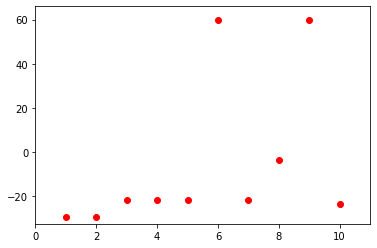

[[3, 2, 0, 1],
 [3, 2, 0, 1],
 [3, 0, 2, 1],
 [3, 0, 2, 1],
 [3, 0, 2, 1],
 [2, 1, 3, 0],
 [3, 0, 2, 1],
 [2, 1, 0, 3],
 [2, 1, 3, 0],
 [3, 0, 1, 2]]

In [41]:
plt.plot(range(1,iterations+1), scores, 'ro')
plt.axis([0, iterations+1, min(scores)*1.1,max(scores)*1.1])
plt.show()
orders

### Nos damos cuenta que necesitamos una busqueda local partiendo de estos ordenes

In [42]:
al_1 = 'TA-TA-AAC'
al_2 = 'T-CT-GAAG'

In [43]:
def neighboard_of(alig):
    neighboard = []
    n_neighboards = 0
    for i in range(0,len(alig)-1):
        if((alig[i]!= '-' and alig[i+1] == '-' )or (alig[i+1]!= '-' and  alig[i] == '-' )):
            a = alig[:i] + alig[i+1] + alig[i] + alig[i+2:]
            neighboard.append((a, (i,i+1)))
            n_neighboards+=1
    return neighboard, n_neighboards

In [44]:
a ,d = neighboard_of(al_1)
a,d

([('T-ATA-AAC', (1, 2)),
  ('TAT-A-AAC', (2, 3)),
  ('TA-T-AAAC', (4, 5)),
  ('TA-TAA-AC', (5, 6))],
 4)

In [45]:
def maximium_local(sequences,order_sequences, score_mtx, gap_penalty,iterations):

    p_max = align_for_order(sequences,order_sequences, score_mtx, gap_penalty)

    align_1,align_2,score_nw = nw(sequences[order_sequences[0]],sequences[order_sequences[1]],score_mtx, gap_penalty)    
    score_history =[(score_nw, align_1, align_2)]
    i = 0
    upgrade_found= True
    while (upgrade_found):
        i+=1
        upgrade_found= False
        print(' ')
        print('iteration', i)
        last_score,a , b = score_history[-1]
        best_score = last_score
        new_best_align_a = a
        new_best_align_b = b
        
        for align_a, align_b in neighboard_of(align_1,align_2):
            
            profile = align_order_with_first_sequences_aligned(align_a, align_b, score_nw, sequences,order_sequences, score_mtx, gap_penalty)
            if(profile.score_history > best_score):
                print('o',end='')
                new_best_align_a = align_a
                new_best_align_b = align_b
                best_score = profile.score_history
                upgrade_found = True
            else:
                print('|',end='')
        score_for_save = (best_score, new_best_align_a, new_best_align_b)
        score_history.append(score_for_save)
    return score_history

In [46]:
def align_order_with_first_sequences_aligned(align_a, align_b,score_nw, sequences,order_sequences, score_mtx, gap_penalty):
    profile_order = Profile()
    profile_order.add_sequence(align_a,score_nw) 
    profile_order.add_sequence(align_b,score_nw)
    for i in order_sequences[2:]:
        seq_align, gaps_profile, score_msa = nw_msa(sequences[i], profile_order, score_mtx, gap_penalty)
        for position_gap in gaps_profile:
            profile_order.add_gap_counter(position_gap)
        profile_order.add_sequence(seq_align,score_msa)
    return profile_order

In [47]:
s0 = [3, 0, 2, 1]
maximium_local(seqs_demo_grasp,s0, score_mtx,  -0.5,10)

20.5
-19.16666666666668
 
iteration 1


TypeError: neighboard_of() takes 1 positional argument but 2 were given

In [ ]:
def msa(sequences, score_mtx, gap_penalty):
    iterations = 10
    
    orders, scores, profiles = nw_GRASP(iterations, sequences, score_mtx, gap_penalty)
    profile = profiles[0]
    
    return maximium_local(profile.sequences, profile.seq_numbers, profile.score_history, score_mtx, gap_penalty)

In [ ]:
def maximium_local(sequences,cant_sequences, score, score_mtx, gap_penalty):
    local_iterations = 100
    history = [score]
    while(i < local_iterations):
        i+=1
        score = correction_with_neightboard(sequences, score, cant_sequences, score_mtx, gap_penalty)
        history.append(score)
    return sequences, history

In [57]:
def correction_with_neightboard(sequences, score, cant_sequences, score_mtx, gap_penalty):
        
    sequence_random = random.randrange(0, profile.cant_sequences)
    
    align = sequences[sequence_random]
    score_correction = 0
    neighboards, cant = neighboard_of(align)
    index_neighboards= list(range(0, cant))
    while(index_neighboards and  score_correction ==0):
        random_value = random.randrange(0, len(index_neighboards))
        index_value.remove(random_value)
        neighboard_random, (column_a,columnb_b) = neighboards[random_value]
        
        prev_score = score_column(sequences,column_a,cant_sequences, score_mtx, gap_penalty) + score_column(sequences,column_b,cant_sequences, score_mtx, gap_penalty)

        sequences[sequence_random] = neighboard_random

        pos_score = score_column(sequences,column_a, cant_sequences, score_mtx, gap_penalty) + score_column(sequences,column_b, cant_sequences, score_mtx, gap_penalty)
        score_correction = pos_score - prev_score
        if(score_correction <= 0):
            sequences[sequence_random] = align
            score_correction = 0

    return score + score_correction

def score_column(sequences, column, cant_sequences, score_mtx, gap_penalty):
    score = 0
    for i in range(0, cant_sequences):
        elem = sequences[i][column]
        for j in range(i+1, cant_sequences):
            elem2 = sequences[j][column]
            score += nucleotides_value(elem,elem2,score_mtx, gap_penalty)
    return score

def nucleotides_value(elem,elem2,score_mtx, gap_penalty):
    index_a = nucleotides.index(elem)
    index_b = nucleotides.index(elem2)
    if(index_a == 4 and index_b == 4):
        return 0
    elif(index_a == 4 or index_b == 4):
        return gap_penalty
    else:
        return score_mtx[index_a][index_b]

In [59]:
msa(sequences, score_mtx, gap_penalty)

3.0